<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

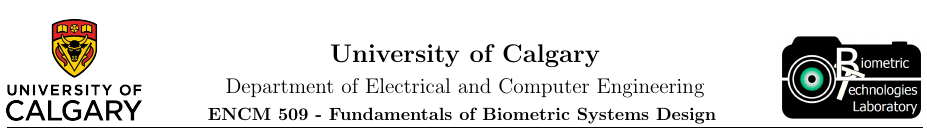

<center>
    <h1>Laboratory Experiment #5</h1>
    <h2>Face Recognition: LBP, PCA and KNN</h2>
</center>

Submitted By: \
Jeff Roszell - 30043087 \
John Matthew San Juan - 10174110 \
Oliver "The Great" Wood - 30004955

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.feature import local_binary_pattern
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from Utils import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

This function is used to evaluate the results **after** classification

In [2]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))
    return acc

### Parameters

In [3]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [4]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


## Descriptor: Local Binary Pattern (LBP)

https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.local_binary_pattern

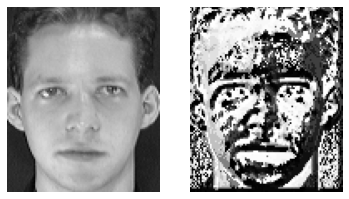

In [5]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

## Preparing the Training and Testing sets

In [6]:
# use the first 5 images from subjects 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" % (subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        trainingFaces.append(np.reshape(lbp, (img.size,)))
        trainingLabels.append(subjectId)
        
# use the last 5 images from subjects 1-n_subjects to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        testingFaces.append(np.reshape(lbp, (img.size,)))
        testingLabels.append(subjectId)

## Classification: K-Nearest Neighbors (KNN)
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [7]:
# Initialization and training of KNN 
# n_neighbors: number of neighbors to use
knn = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(trainingFaces, trainingLabels)

### Prediction with the Testing set

In [8]:
predictedLabels = knn.predict(testingFaces)

### Evaluating the Results

In [9]:
orig_lbp_acc = prediction_evaluation(predictedLabels, testingLabels, subject_id=1)

Overall Accuracy: 74%
Subject #1:
	TP: 3, FP: 0, TN: 95, FN: 2
	TPR: 60.00%, TNR: 100.00%, FPR: 0.00%, FNR: 40.00%


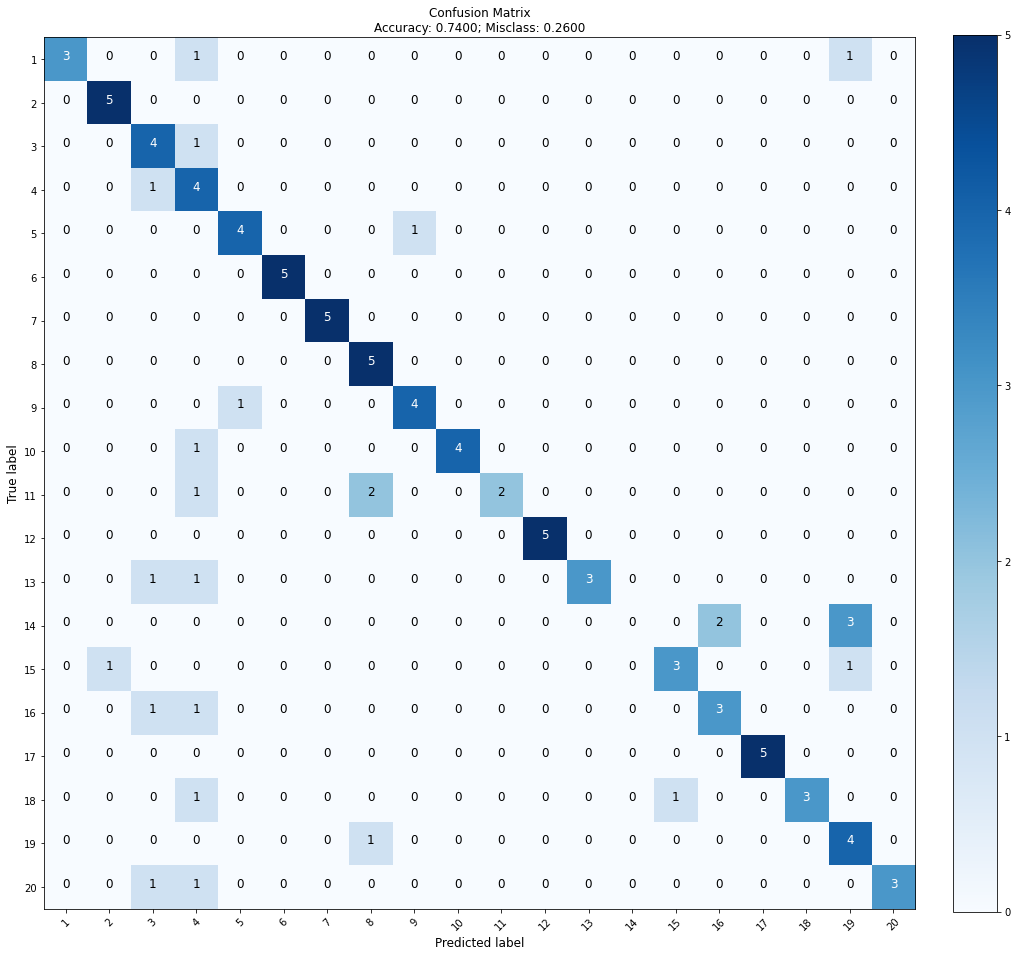

In [10]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# Plot the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,
                      target_names=[i for i in range(1, n_subjects+1)])

### Descriptor: Principal Component Analysis (PCA)

In [11]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

### Initializing the PCA

In [12]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

#### Apply PCA to the two sets: Training and Test

In [13]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

#### Mean image

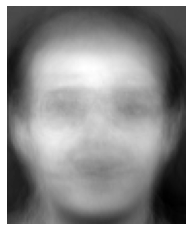

In [14]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

#### Eigenfaces

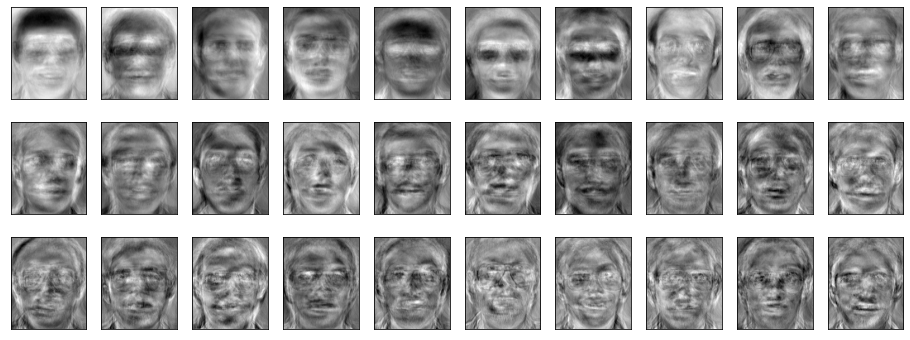

In [15]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [16]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [17]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results

In [18]:
orig_pca_acc = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 91%
Subject #1:
	TP: 4, FP: 0, TN: 95, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


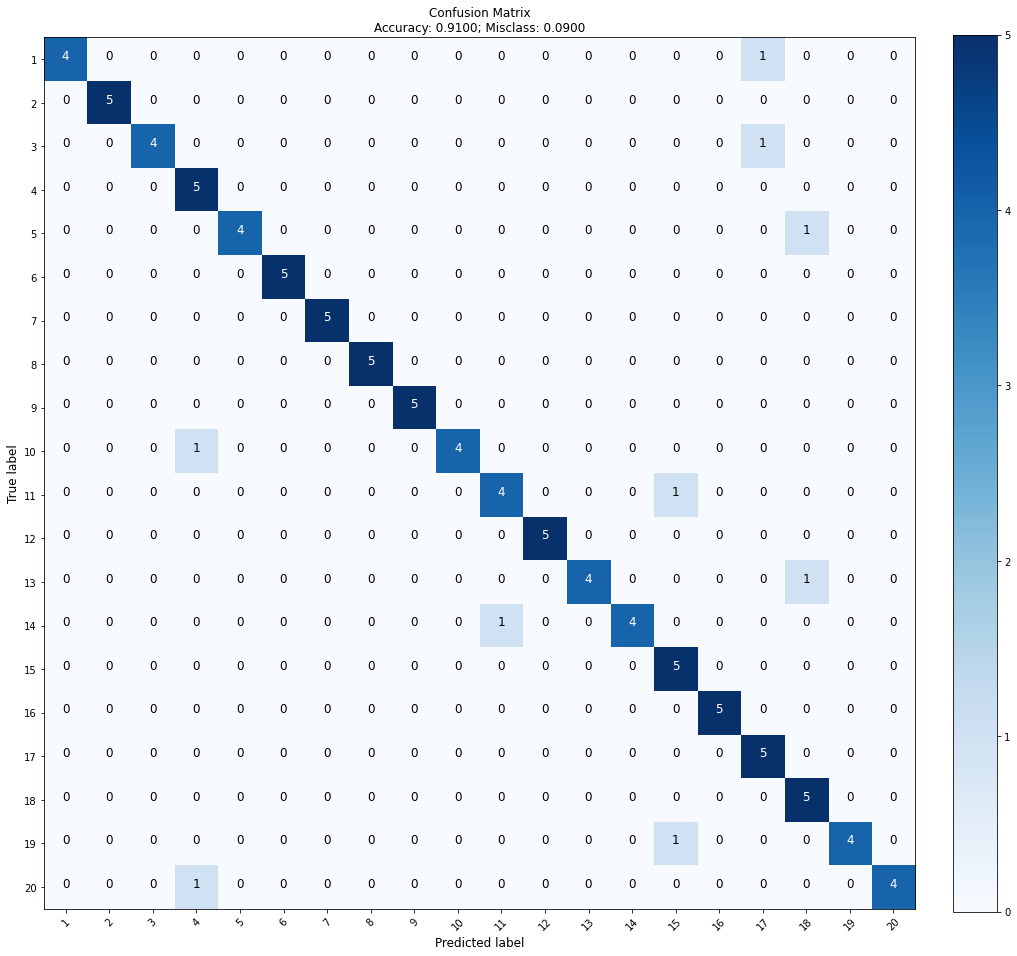

In [19]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Extra Information (for Bonus): Neighbors Analysis

Have you tought about "**what are the 3 nearest neighbors of one sample**"?
(Here we are using 3 but could be any number of neighbors)

Let's take the first sample (index `0`) of the testing set:

In [20]:
sampleX = test_pca[0]

# need to reshape: 1 row by N columns
sampleX = sampleX.reshape((1,sampleX.size))

Getting the `n_neighbors` of this `sampleX`. The return of the function `kneighbors` are:
- `neigh_dist`: the distancies of 3 nearest neighbors.
- `neigh_ind`: the indexes of these neighbors in the `testingLabels`.

In [21]:
neigh_dist, neigh_ind = knn_pca.kneighbors(sampleX, n_neighbors=3)

The indexes of the 3 neighbors:

In [22]:
neigh_ind

array([[ 3, 24,  0]], dtype=int64)

Calling the `predict` function to check to each class belongs the `sampleX`:

In [23]:
knn_pca.predict(sampleX)

array([1])

Now we can recover from `testingLabels` variable to which classes the 3 neighbors belong. 

Below we recorver the original classes and show the distances between `sampleX` and each neighbor. It is expected that the closest neighbor OR the majority of neighbors will be from the same class as the one returnd by `predict` above.

In [24]:
for x,dist in zip(neigh_ind[0], neigh_dist[0]):
    print('class: %d --> dist: %.2f' % (testingLabels[x], dist))

class: 1 --> dist: 2694.07
class: 5 --> dist: 3784.59
class: 1 --> dist: 4167.64


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

### Introduction
In the following exercises we will be discussing KNN or k nearest neigbours algorithm and how it can be applied to the problem of facial recognition. Additionally we will be exploring the affects of LBP or local binary point as well as PCA principle component analysis as preprocessing efforts before KNN was used. Each exercise will involve adjusting different parameters. Number of components, number of facial samples, and the quantity of neighbours are the parameters that wikl be adjusted. There will be an analysis after each step to see if there any patterns or trends that come of the adjustments.

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier  accuracy, and visualize the comparison using the bar plot. Your bar plot shall have 3 bars, based on the number of components: 50, 100 (already done) and 200.

### Principal Component Analysis with 50 Principal components) 

In [25]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [26]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


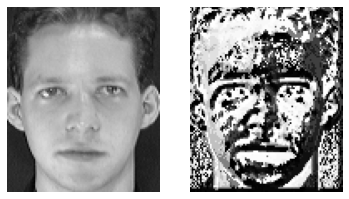

In [27]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [28]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [29]:
# n_components: number of principal components
pca = PCA(n_components=50)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [30]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

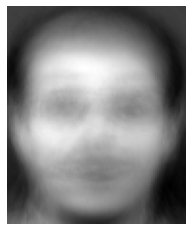

In [31]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

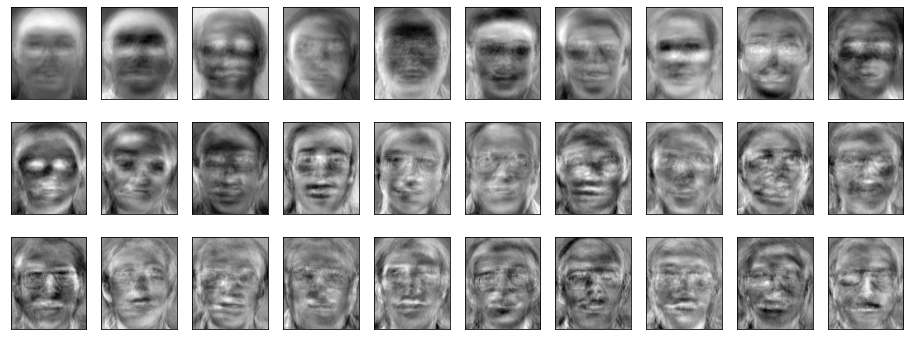

In [32]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [33]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [34]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results for 50 Principal components

In [35]:
acc_50 = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


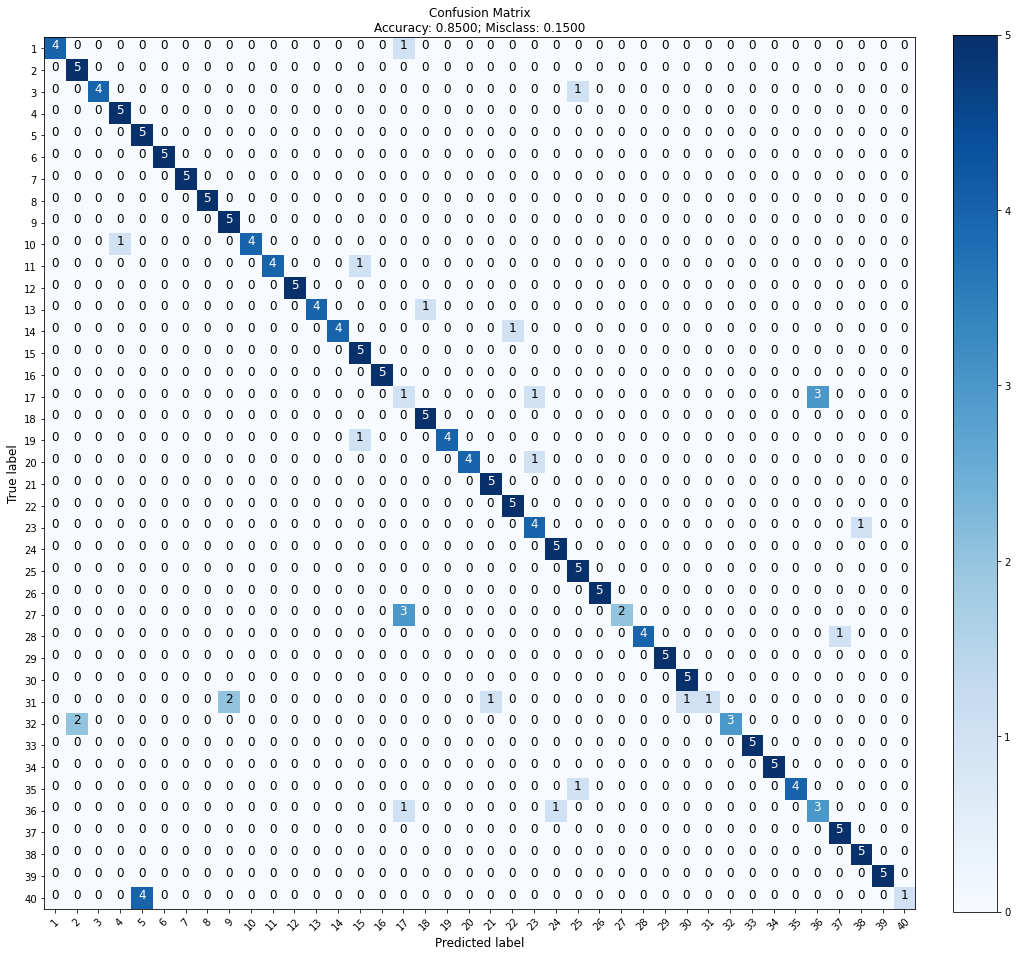

In [36]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

### Principal Component Analysis with 100 Principal components) 

In [37]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [38]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


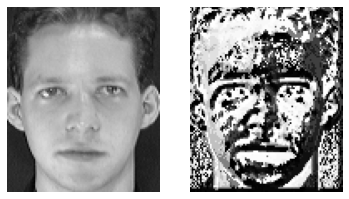

In [39]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [40]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [41]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [42]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

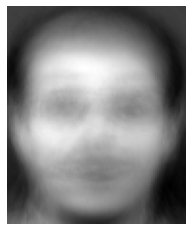

In [43]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

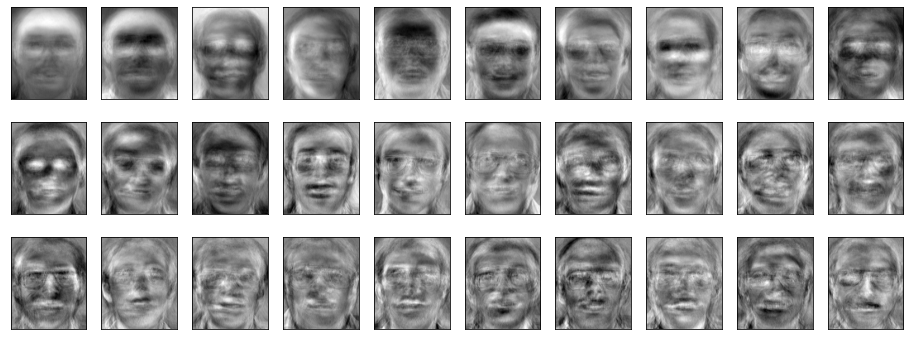

In [44]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [45]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [46]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results for 100 Principal components

In [47]:
acc_100 = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


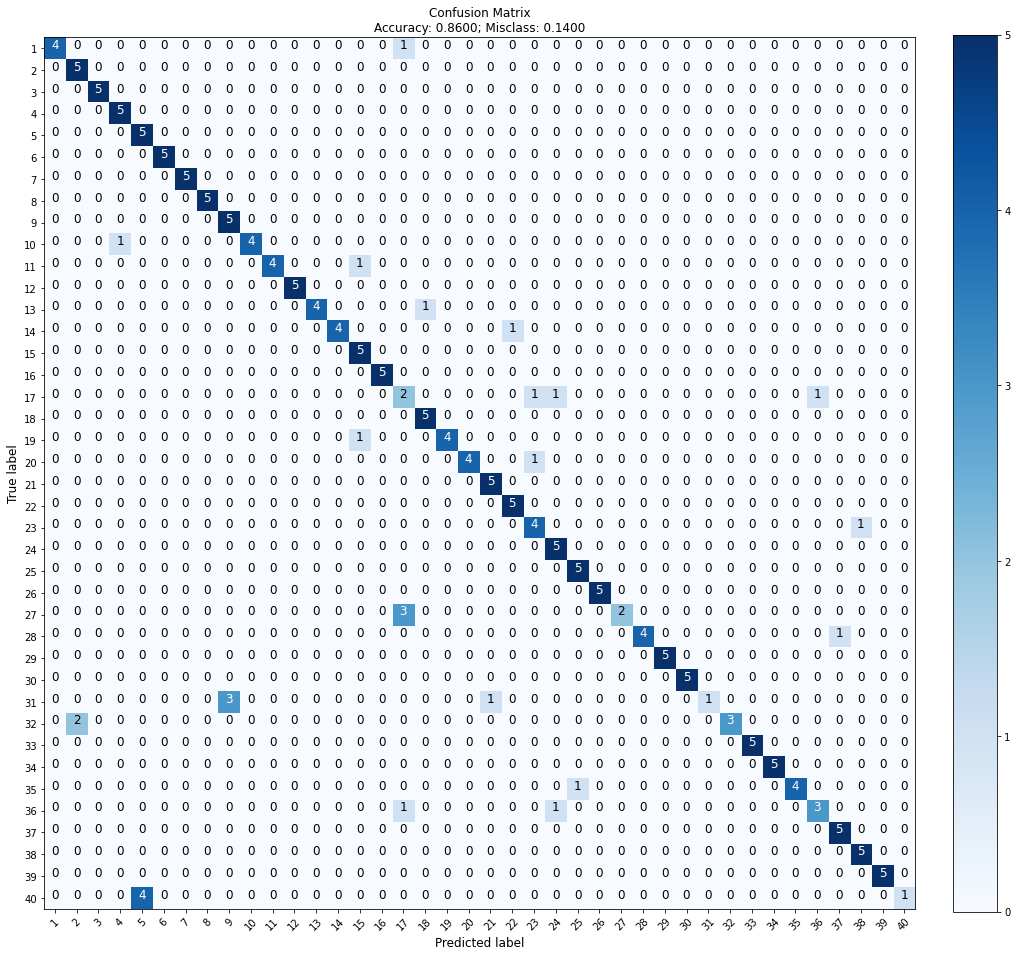

In [48]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

### Principal Component Analysis with 200 Principal components

In [49]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [50]:
# n_components: number of principal components
pca = PCA(n_components=200)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [51]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

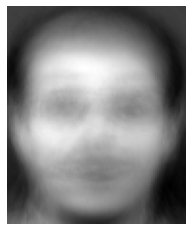

In [52]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

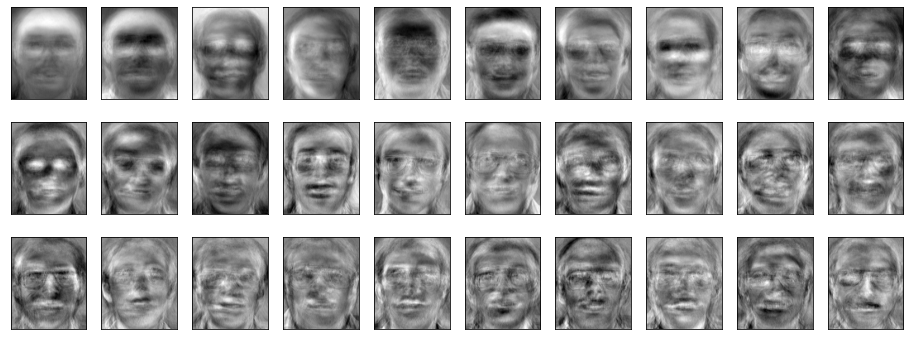

In [53]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [54]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [55]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results for 200 Principal components

In [56]:
acc_200 = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


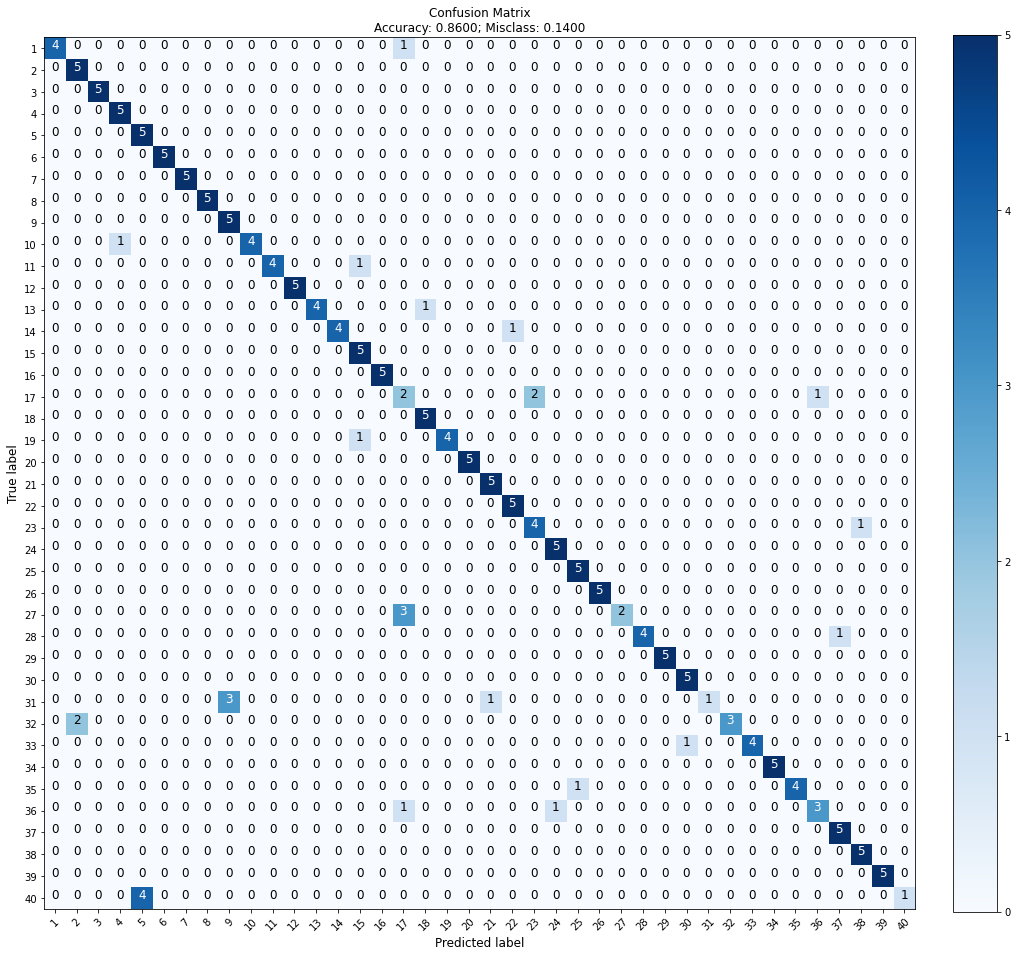

In [57]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Exercise 1 Analysis

Accuracy for 50 PCA is:  0.85
Accuracy for 100 PCA is:  0.86
Accuracy for 200 PCA is:  0.86


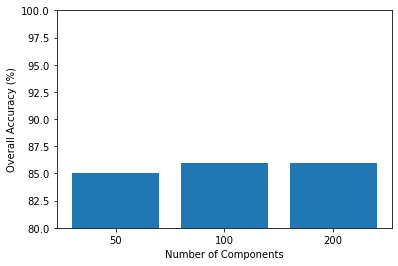

In [58]:
print("Accuracy for 50 PCA is: ", acc_50)
print("Accuracy for 100 PCA is: ", acc_100)
print("Accuracy for 200 PCA is: ", acc_200)


class_acc = [acc_50 * 100, acc_100 * 100, acc_200* 100]
num_PCA = ['50', '100', '200']

plt.bar(num_PCA, class_acc)
plt.xlabel('Number of Components')
plt.ylabel('Overall Accuracy (%)')
plt.ylim (80, 100)

plt.show()

### Exercise 1 Discussion
The goal of PCA is to be able to simplify a model and have an outcome of roughly the same accuracy. In the case of exercise one we were able to show that the accuracy only changed by a percent going from 200 to 100 to 50. Reflecting upon this, it is easy to see that reduction of components in this case has led to almost no change in accuracy in predicting the correct matching class. If we were to look at the algorithm behind this prediction we could see that with every step down in components, the explanation becomes clearer and easier.

- **Exercise 2** (4 marks): In this exercise you will evaluate how the amount of data used to train the classifier (KNN) impacts the results. In your Jupyter notebook, consider 20 subjects, and set the number of images used for training as 8  and remaining 2 for testing. Compare your results with the one shown in this lab description for both the PCA and LBP descriptors and draw the conclusions.

## Exercise 2: Changing Training Parameters

In [59]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [60]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]


### Descriptor: Local Binary Pattern (LBP)

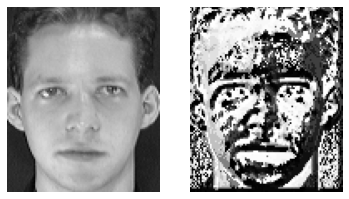

In [61]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [62]:
# use the first 8 images from subjects 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" % (subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        trainingFaces.append(np.reshape(lbp, (img.size,)))
        trainingLabels.append(subjectId)
        
# use the last 2 images from subjects 1-n_subjects to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        testingFaces.append(np.reshape(lbp, (img.size,)))
        testingLabels.append(subjectId)

In [63]:
# Initialization and training of KNN 
# n_neighbors: number of neighbors to use
knn = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(trainingFaces, trainingLabels)

In [64]:
predictedLabels = knn.predict(testingFaces)

### Evaluating the LBP Results for 8 training images

In [65]:
ex2_lbp_acc = prediction_evaluation(predictedLabels, testingLabels, subject_id=1)

Overall Accuracy: 80%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


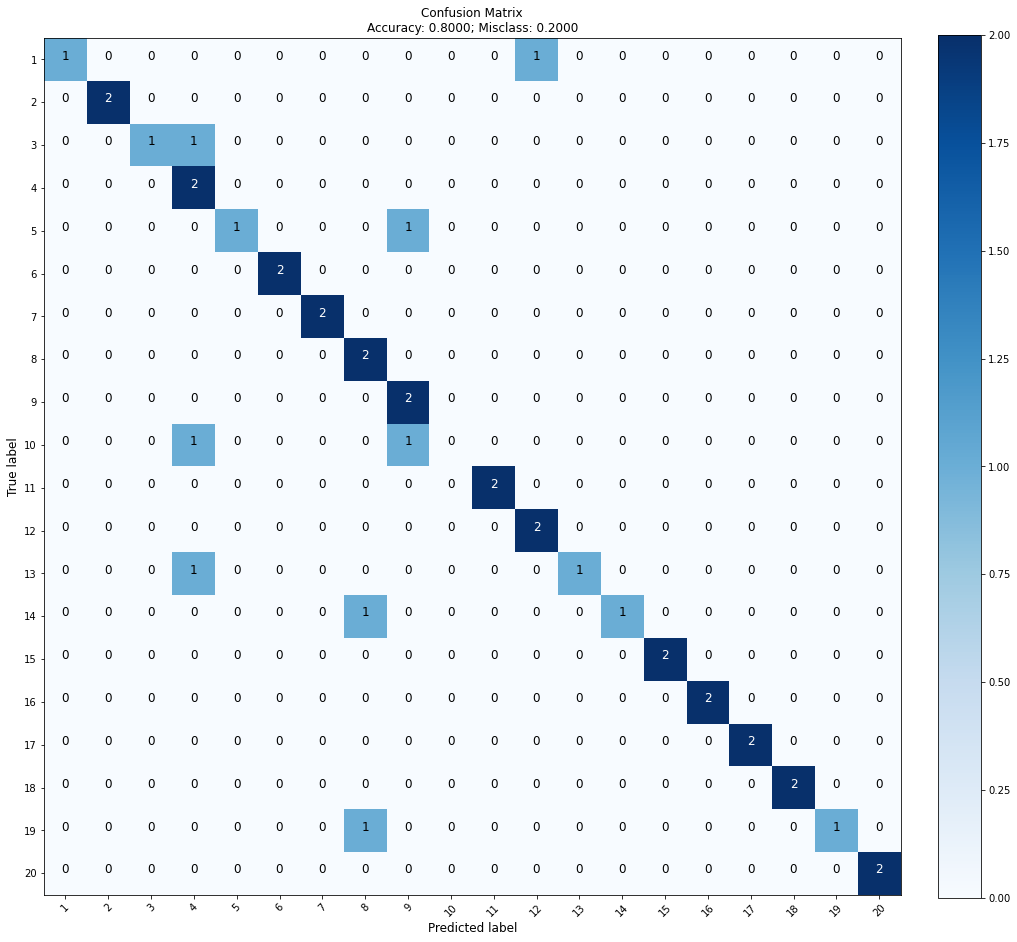

In [66]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# Plot the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,
                      target_names=[i for i in range(1, n_subjects+1)])

### Descriptor: Principal Component Analysis (PCA)

In [67]:
# use the first 8 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 2 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [68]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [69]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

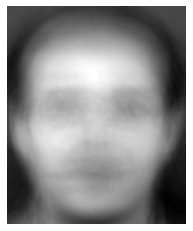

In [70]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

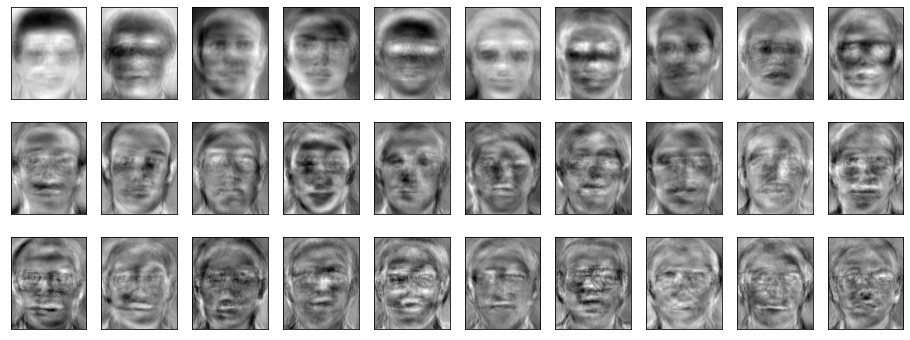

In [71]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [72]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [73]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the PCA Results for 8 training images

In [74]:
ex2_pca_acc = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


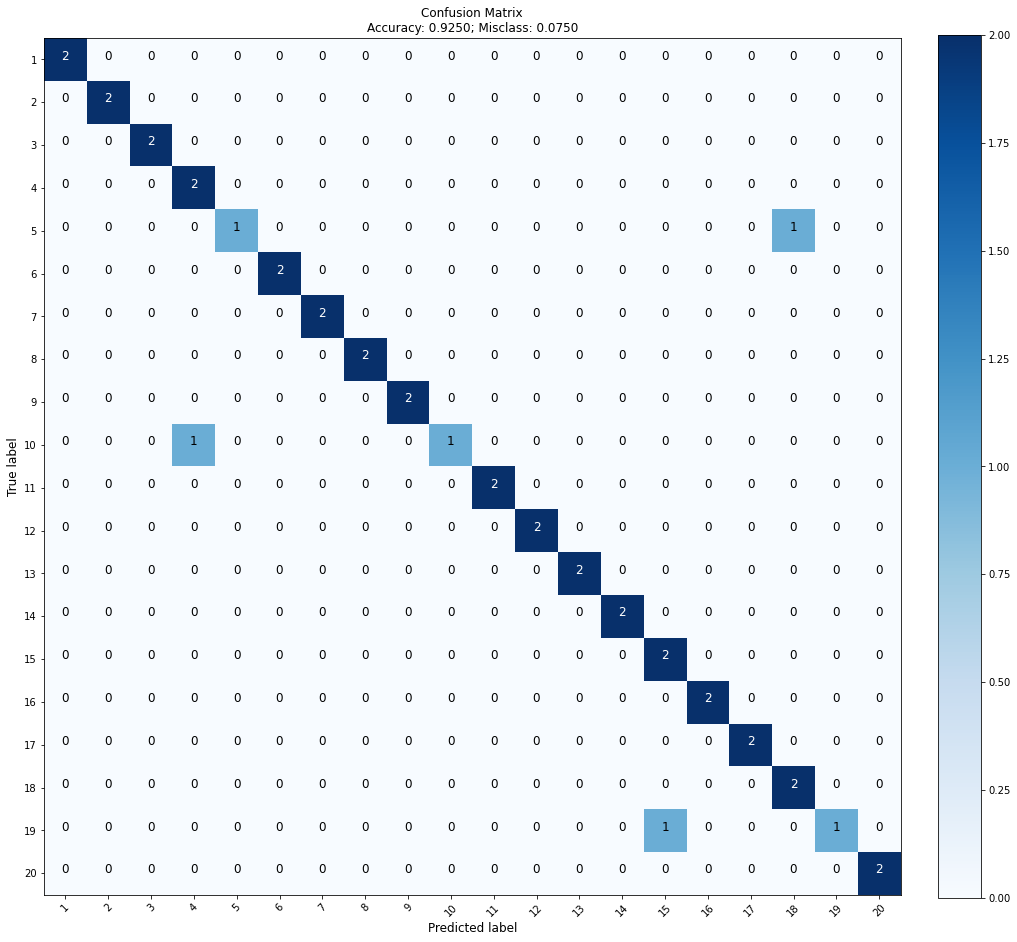

In [75]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Exercise 2 Analysis

In [76]:
print("Overall Accuracy for LBP:\n"
      "Trained with 5 images = ",orig_lbp_acc * 100, "%\n"
      "Trained with 8 images = ",ex2_lbp_acc * 100, "%\n")

print("Overall Accuracy for PCA:\n"
      "Trained with 5 images = ",orig_pca_acc * 100, "%\n"
      "Trained with 8 images = ",ex2_pca_acc * 100, "%")

Overall Accuracy for LBP:
Trained with 5 images =  74.0 %
Trained with 8 images =  80.0 %

Overall Accuracy for PCA:
Trained with 5 images =  91.0 %
Trained with 8 images =  92.5 %


### Exercise 2 Discussion
This is a theme that has been seen in earlier labs. As we increase the sample size for each of the training faces, we can improve the accuracy of the prediction. This exercise shows that if we increase from 5 to 8 to 11 and it shows a very normal increase in the accuracy. Additionally we used two pre processing techniques which showed similar performance, with PCA edging out LBP only slightly in the end.

- **Exercise 3** (3 marks): Now you will evaluate the impact of the number of neighbors (`K`) defined for the KNN. Using the same data separation  (20 subjects, 8 images per subject are used for training and 2 for testing), conduct the two  experiments considering, for example: 1) 5 neighbors and, 2) 11 neighbors. For each experiment, evaluate both LBP and PCA (using the parameters already defined in the notebook). Compare your results and draw the conclusions.

## Exercise 3: Changing KNN Parameters - Part 1

In [77]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors = 5

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [78]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]


### Descriptor: Local Binary Pattern (LBP)

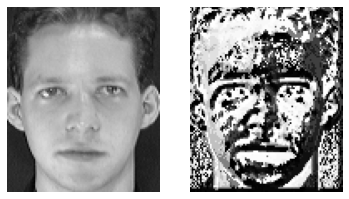

In [79]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [80]:
# use the first 8 images from subjects 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" % (subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        trainingFaces.append(np.reshape(lbp, (img.size,)))
        trainingLabels.append(subjectId)
        
# use the last 2 images from subjects 1-n_subjects to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        testingFaces.append(np.reshape(lbp, (img.size,)))
        testingLabels.append(subjectId)

In [81]:
# Initialization and training of KNN 
# n_neighbors: number of neighbors to use
knn = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(trainingFaces, trainingLabels)

In [82]:
predictedLabels = knn.predict(testingFaces)

### Evaluating the LBP Results for 5 knn

In [83]:
ex3_lbp_acc_5knn = prediction_evaluation(predictedLabels, testingLabels, subject_id=1)

Overall Accuracy: 72%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


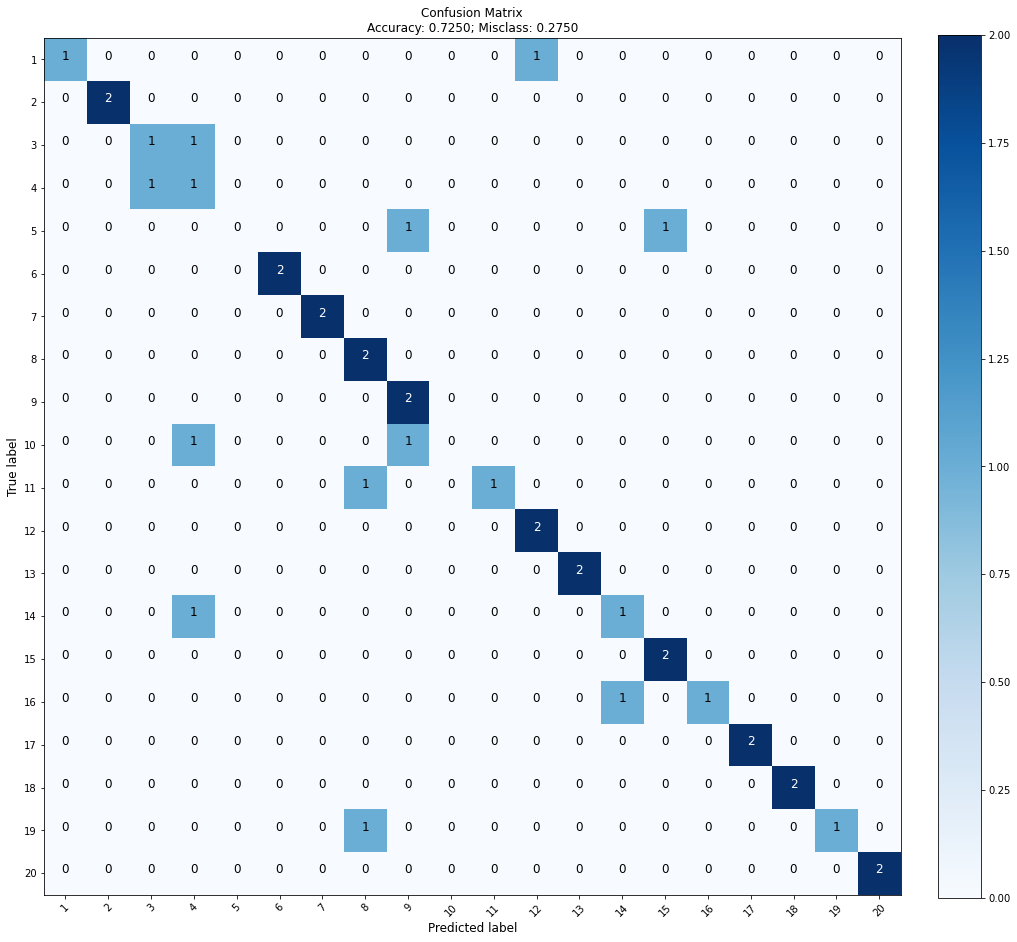

In [84]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# Plot the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,
                      target_names=[i for i in range(1, n_subjects+1)])

### Descriptor: Principal Component Analysis (PCA)

In [85]:
# use the first 8 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 2 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [86]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [87]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

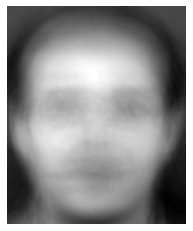

In [88]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

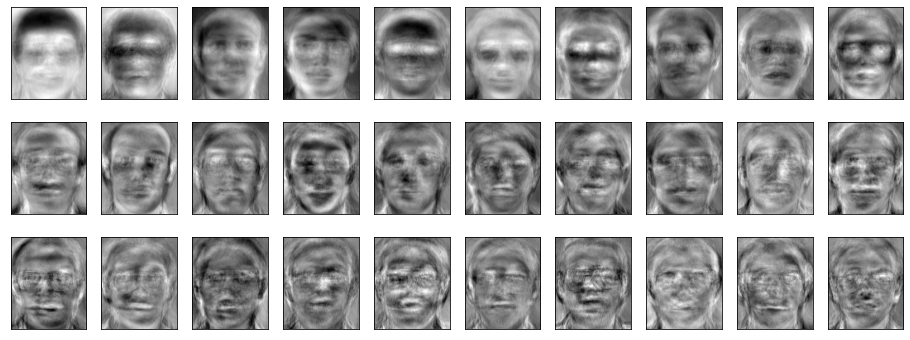

In [89]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [90]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [91]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the PCA Results for 5 knn

In [92]:
ex3_pca_acc_5knn = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


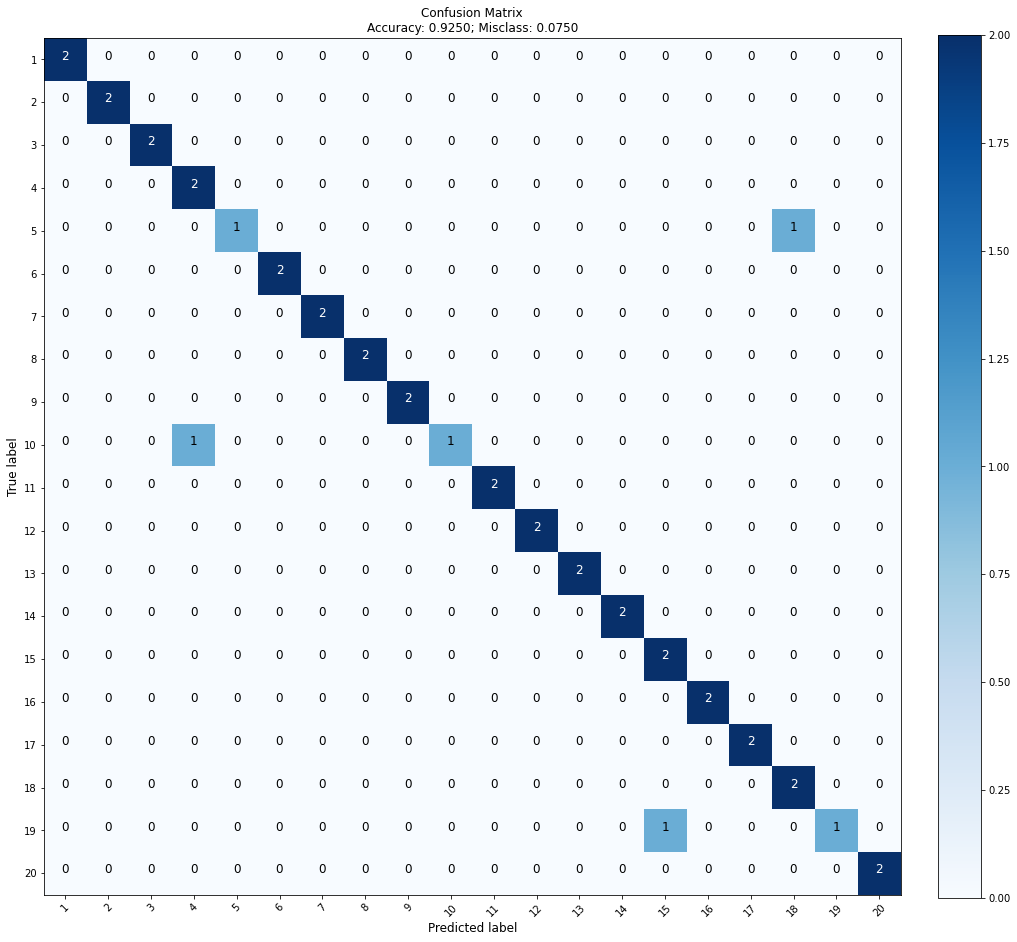

In [93]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Exercise 3: Changing KNN Parameters - Part 2

In [94]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors = 11

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [95]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]


### Descriptor: Local Binary Pattern (LBP)

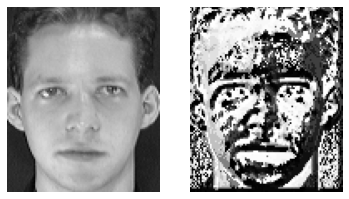

In [96]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [97]:
# use the first 8 images from subjects 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" % (subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        trainingFaces.append(np.reshape(lbp, (img.size,)))
        trainingLabels.append(subjectId)
        
# use the last 2 images from subjects 1-n_subjects to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        lbp = local_binary_pattern(img, 12, 3)
        testingFaces.append(np.reshape(lbp, (img.size,)))
        testingLabels.append(subjectId)

In [98]:
# Initialization and training of KNN 
# n_neighbors: number of neighbors to use
knn = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(trainingFaces, trainingLabels)

In [99]:
predictedLabels = knn.predict(testingFaces)

### Evaluating the LBP Results for 11 knn

In [100]:
ex3_lbp_acc_11knn = prediction_evaluation(predictedLabels, testingLabels, subject_id=1)

Overall Accuracy: 72%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


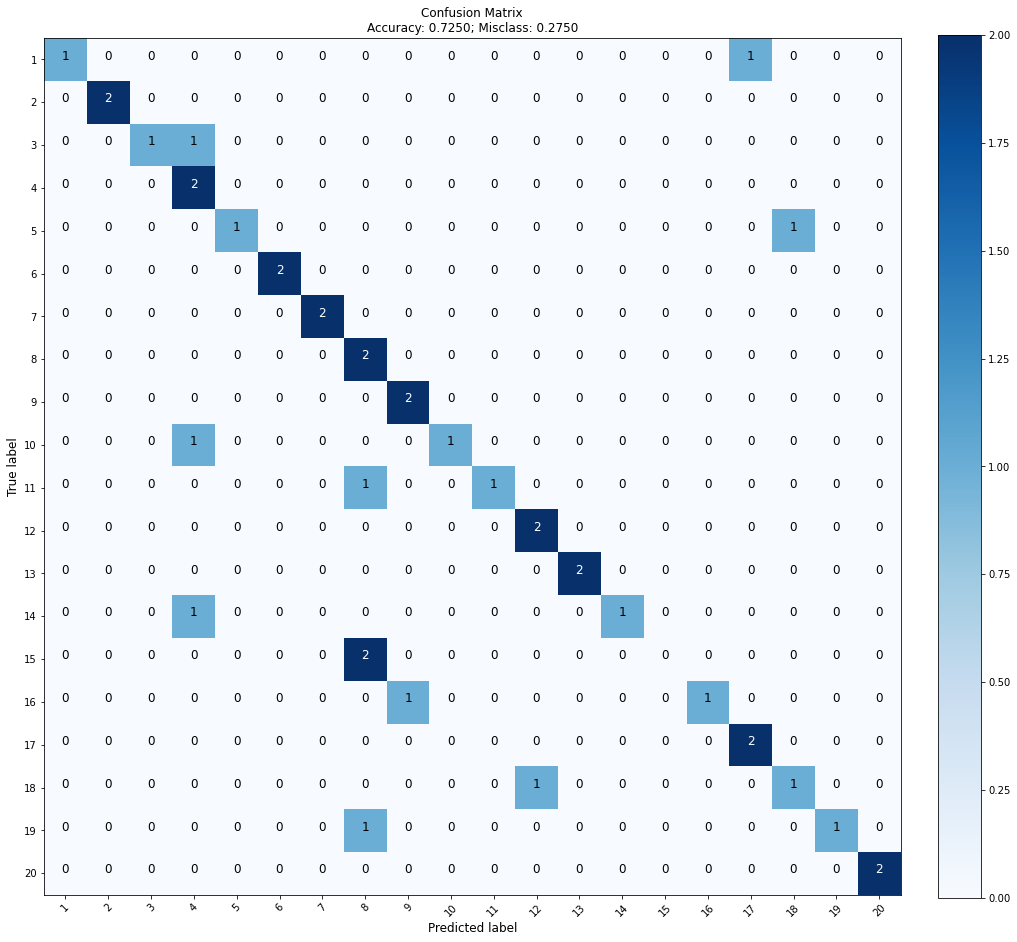

In [101]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# Plot the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,
                      target_names=[i for i in range(1, n_subjects+1)])

In [102]:
### Descriptor: Principal Component Analysis (PCA)

In [103]:
# use the first 8 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 2 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [104]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [105]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

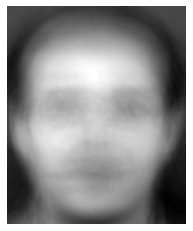

In [106]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

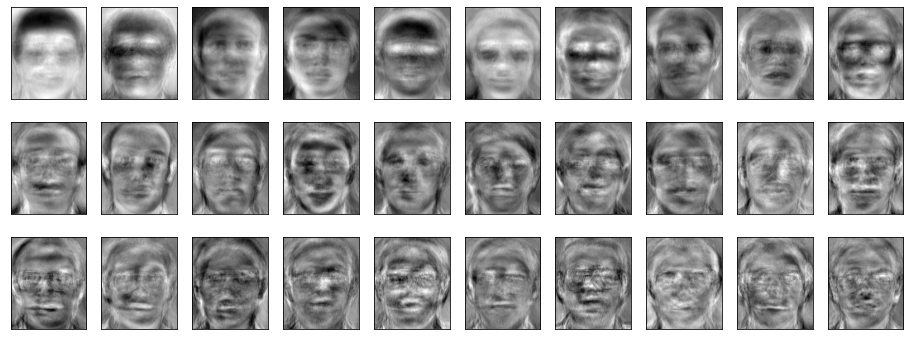

In [107]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [108]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [109]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the PCA Results for 11 knn

In [110]:
ex3_pca_acc_11knn = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 77%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


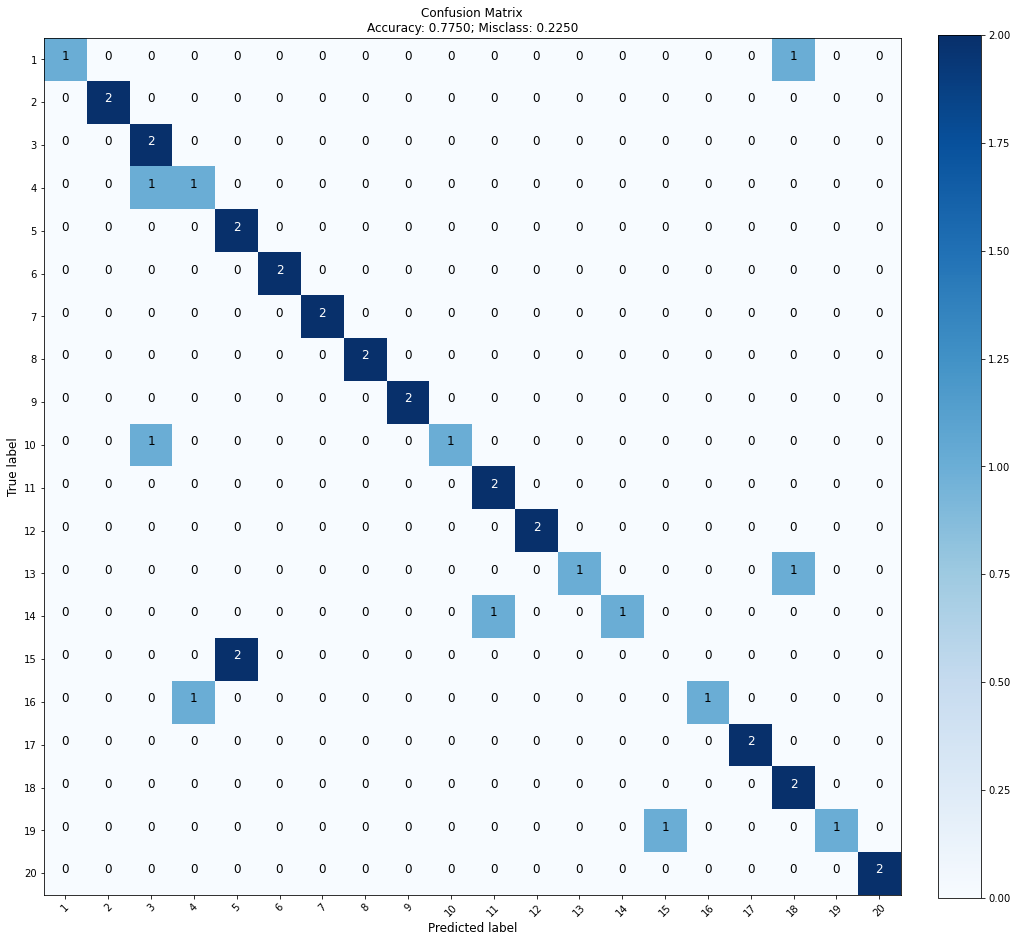

In [111]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Exercise 3 Analysis

In [112]:
print("Overall Accuracy for LBP:\n"
      "Trained with 3 knn = ",ex2_lbp_acc * 100, "%\n"
      "Trained with 5 knn = ",ex3_lbp_acc_5knn * 100, "%\n"
      "Trained with 11 knn = ",ex3_lbp_acc_11knn * 100, "%\n")

print("Overall Accuracy for PCA:\n"
      "Trained with 3 knn = ",ex2_pca_acc * 100, "%\n"
      "Trained with 5 knn = ",ex3_pca_acc_5knn * 100, "%\n"
      "Trained with 11 knn = ",ex3_pca_acc_11knn * 100, "%\n")

Overall Accuracy for LBP:
Trained with 3 knn =  80.0 %
Trained with 5 knn =  72.5 %
Trained with 11 knn =  72.5 %

Overall Accuracy for PCA:
Trained with 3 knn =  92.5 %
Trained with 5 knn =  92.5 %
Trained with 11 knn =  77.5 %



### Exercise 3 Discussion
KNN works on classifying a test sample based on a distanced arrangement of the trained samples around it. As with exercise 3 we preprocessed with LBP and PCA seperately. The results show a very peculiar pattern, which shows that 3 KNN is actually a more accurate predictor with regards to these facial recognition examples. A possible explanation that with the added KNN we were taking in results which confused the system with non-matching samples. This may have led to a drop in the predictive powers of the KNN model.

- **BONUS exercise** (3 marks): This exercise is about ranking-based face classification. So far, in case of the KNN, we considered the predicted label using the function `predict(...)`. This function returns the  closest neighbor to a specific sample, that is, Rank-1 result. The idea of Rank-K ranking is the finding the K closest (top) neighbor classes,  for example the closest 3, and analyze which classes are among those 3. Now, modify the code provided  (see in the notebook the extra section *Neighbor Analysis*) to evaluate the classification based on Rank-3. Compare your results against the Rank-1 results which is already done in the Lab notebook.

## BONUS Exercise (Using Exercise 1 Parameters)

In [113]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = './ATT dataset/'

In [114]:
print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


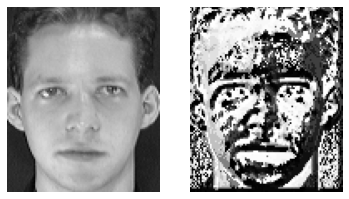

In [115]:
# Plot one image of subject 1 from dataset
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

# Extract LBP feature from the image, and plot the feature
# P: Number of circularly symmetric neighboor set points = 12
# Q: Radius of circle = 3
# (original local binary pattern which is gray scale but not rotation invariant)
lbp = local_binary_pattern(img, 12, 3)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp); plt.axis('off');

In [116]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread(path + "ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [117]:
# n_components: number of principal components
pca = PCA(n_components=100)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [118]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

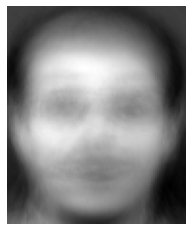

In [119]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

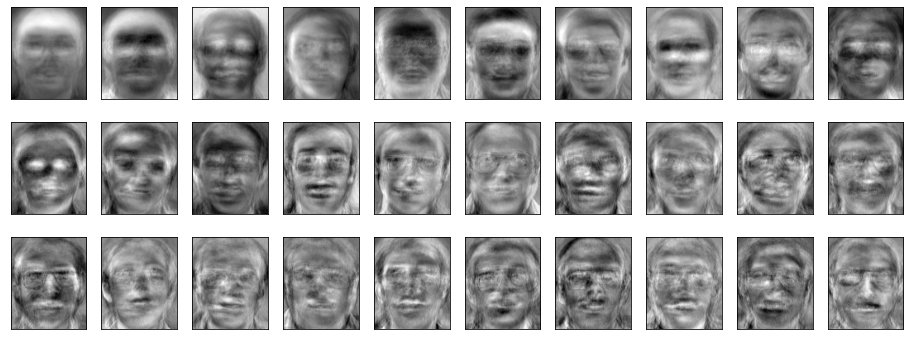

In [120]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [121]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [122]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results for 100 Principal components

In [123]:
acc_100 = prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


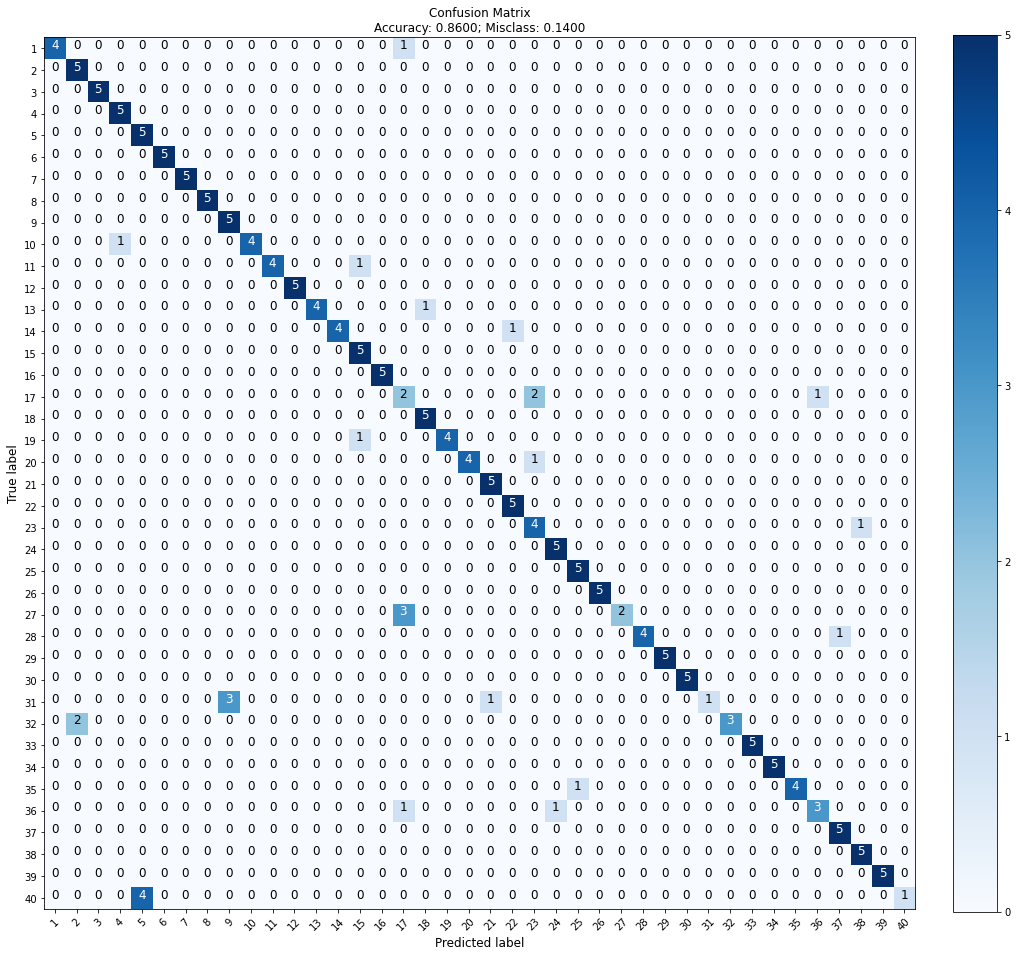

In [124]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

In [125]:
sampleX = test_pca[0]

# need to reshape: 1 row by N columns
sampleX = sampleX.reshape((1,sampleX.size))

In [126]:
neigh_dist, neigh_ind = knn_pca.kneighbors(sampleX, n_neighbors=3)

In [127]:
neigh_ind

array([[  3,  24, 174]], dtype=int64)

In [128]:
knn_pca.predict(sampleX)

array([1])

In [129]:
for x,dist in zip(neigh_ind[0], neigh_dist[0]):
    print('class: %d --> dist: %.2f' % (testingLabels[x], dist))

class: 1 --> dist: 2826.97
class: 5 --> dist: 3838.49
class: 35 --> dist: 3923.85


In [130]:
img = imread(path + "ATT dataset/s1/1.pgm", as_gray=True)

Sample vs Rank 1 from Class 1


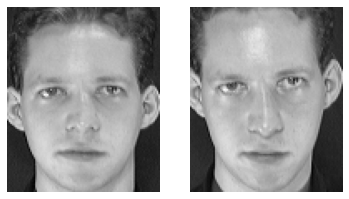

In [131]:
print("Sample vs Rank 1 from Class", (int((neigh_ind[0][0])/5) + 1))
string1 =  "ATT dataset/s%d/%d.pgm" % ((int((neigh_ind[0][0])/5) + 1),((neigh_ind[0][0])%5))
#string1 =  "ATT dataset/s1/3.pgm"

img1 = imread(path + string1 , as_gray=True)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1); plt.axis('off');      




Sample vs Rank 2 from Class 5


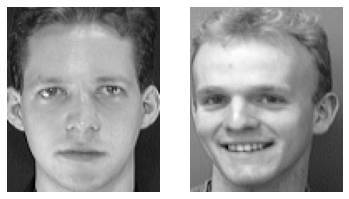

In [132]:
print("Sample vs Rank 2 from Class", (int((neigh_ind[0][1])/5) + 1))
string2 =  "ATT dataset/s%d/%d.pgm" % ((int((neigh_ind[0][1])/5) + 1),((neigh_ind[0][1])%5))
img2 = imread(path + string2 , as_gray=True)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2); plt.axis('off');      

Sample vs Rank 3 from Class 35


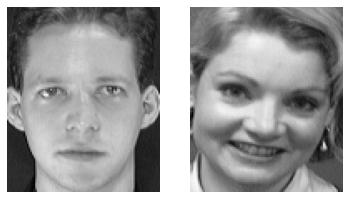

In [133]:
print("Sample vs Rank 3 from Class", (int((neigh_ind[0][2])/5) + 1))
string3 =  "ATT dataset/s%d/%d.pgm" % ((int((neigh_ind[0][2])/5) + 1),((neigh_ind[0][2])%5))
img3 = imread(path + string3 , as_gray=True)

plt.subplot(1,2,1)
plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img3); plt.axis('off');   

## BONUS Exercise Analysis

Comparing the top 3 nearest neighbors, the algorithm was able to choose the correct class.

#### Bonus Discussion
In this bonus exercise we looked at adjusting the k-ranking, which is the range for which we wanted displayed. We thought of this as "which trained classes are close to the test sample". With this we adjusted the ranking to three, which allowed us to see the top three choices which matched closely to the test sample. This may have many implications, such as grouping the examples rather than just looking at which one most perfectly fits. This could work for something such as relatives or members of the same sex, or similar ethnicity.


### Conclusion
In this lab we were able to observe a few things. Starting with the various effects of preprocessing the data before classification, which turned out to be mostly postive and fairly helpful in minimizing the work of the algorithm. Next we took a look at how the number of compnents changed (in this case didn't change) the outcome of the prdeiction and its accuracy. Next up was the sample quantity, which as illustrated previously in other labs, was a great help in improving the overall accuracy regardless of the preprocessing technique used. The third exercise showed how the number of neighbours most likely has a "sweet spot" where it provides an accurate prediction without introducing too many extraneous variables. And lastly there a bonus activity which showed how we could use these techniques to show more than just the perfect fit, perhaps instead showing things which were "alike" or "similar" by increasing the ranking of the KNN. Quite an informative lab, and really helped with the understading of KNN.